<a href="https://www.kaggle.com/code/valece/xgbregressor-r2-0-96?scriptVersionId=190389044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow import keras

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

2024-07-30 04:59:17.983844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 04:59:17.984038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 04:59:18.173610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data

In [2]:
df = pd.read_csv("/kaggle/input/mobile-phone-price-prediction-cleaned-dataset/Mobile-Price-Prediction-cleaned_data.csv")
df.head()

,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
0,4.3,4.0,128.0,6.00,48,13.0,4000,24999
1,3.4,6.0,64.0,4.50,48,12.0,4000,15999
2,4.3,4.0,4.0,4.50,64,16.0,4000,15000
3,4.4,6.0,64.0,6.40,48,15.0,3800,18999
4,4.5,6.0,128.0,6.18,35,15.0,3800,18999


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ratings        807 non-null    float64
 1   RAM            807 non-null    float64
 2   ROM            807 non-null    float64
 3   Mobile_Size    807 non-null    float64
 4   Primary_Cam    807 non-null    int64  
 5   Selfi_Cam      807 non-null    float64
 6   Battery_Power  807 non-null    int64  
 7   Price          807 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 50.6 KB


In [4]:
df.describe()

,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
count,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000
mean,4.112639,5.941760,64.390335,5.620660,47.821561,8.868649,3278.859975,14269.167286
std,0.367830,2.056359,53.868626,3.957409,11.155916,4.547254,937.628801,23092.739983
min,2.800000,0.000000,2.000000,2.000000,5.000000,0.000000,1020.000000,479.000000
25%,3.900000,6.000000,32.000000,4.500000,48.000000,8.000000,3000.000000,984.000000
50%,4.100000,6.000000,32.000000,4.770000,48.000000,8.000000,3000.000000,1699.000000
75%,4.400000,6.000000,64.000000,6.300000,48.000000,12.000000,3800.000000,18994.500000
max,4.800000,12.000000,256.000000,44.000000,64.000000,23.000000,6000.000000,153000.000000


# EDA

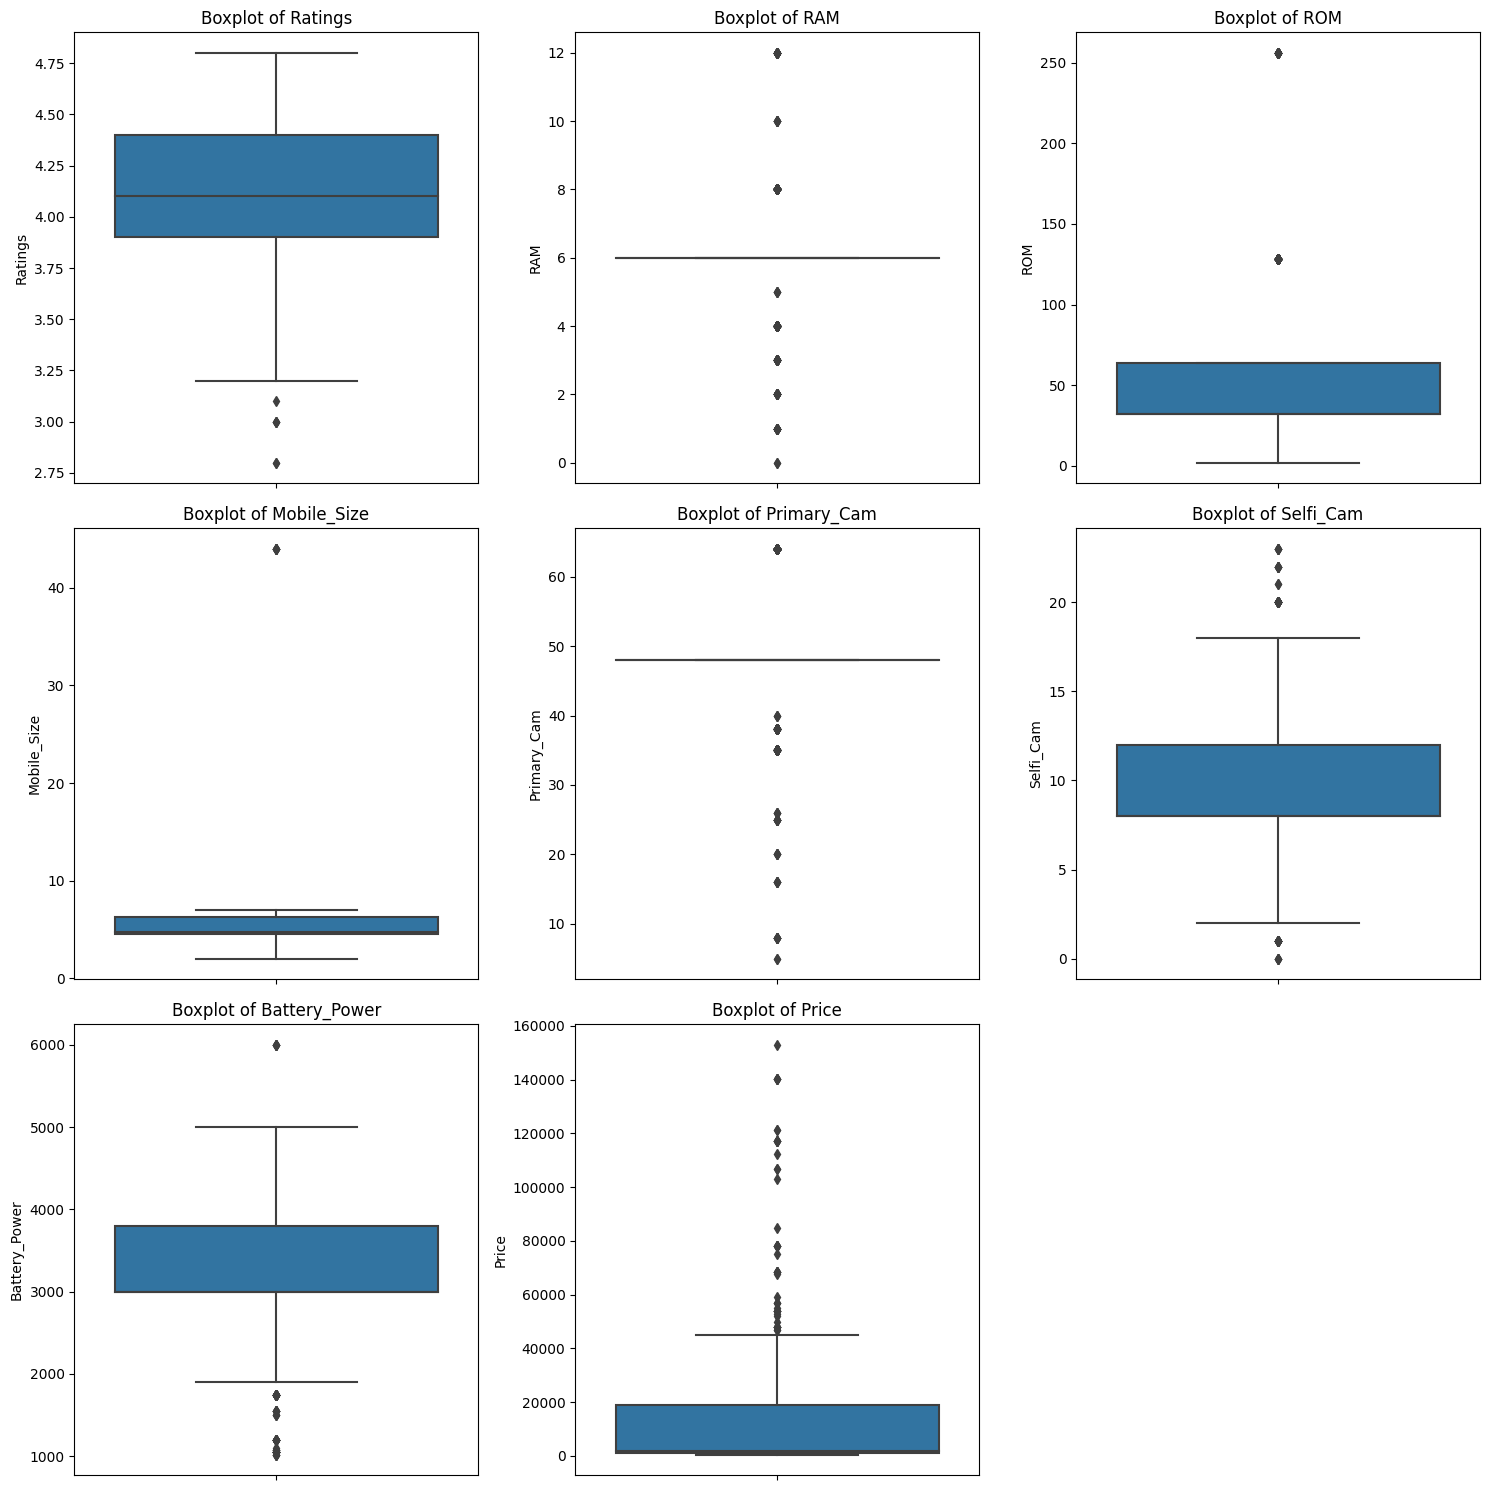

In [5]:
num_columns = 3
num_plots = len(df.columns) - 1
num_rows = (num_plots + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [6]:
count = (df["Primary_Cam"] < 40).sum()
count

187

In [7]:
count = (df["ROM"] > 250).sum()
count

33

In [8]:
count = (df["Mobile_Size"] > 40).sum()
count

8

In [9]:
# Clean outliers
def remove_outliers_iqr(df):
    for column in df.select_dtypes(include=[np.number]).columns: 
        LI = df[column].quantile(0.10)
        LS = df[column].quantile(0.90)
        interval = LS - LI
        
        lower_bound = LI - 1.5 * interval
        upper_bound = LS + 1.5 * interval
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_clean = remove_outliers_iqr(df)
df_clean = df_clean[df_clean["ROM"]<250]
df_clean = df_clean[df_clean["Mobile_Size"]<40]
print(f"Original data shape: {df.shape}")
print(f"Cleaned data shape: {df_clean.shape}")

Original data shape: (807, 8)
Cleaned data shape: (749, 8)


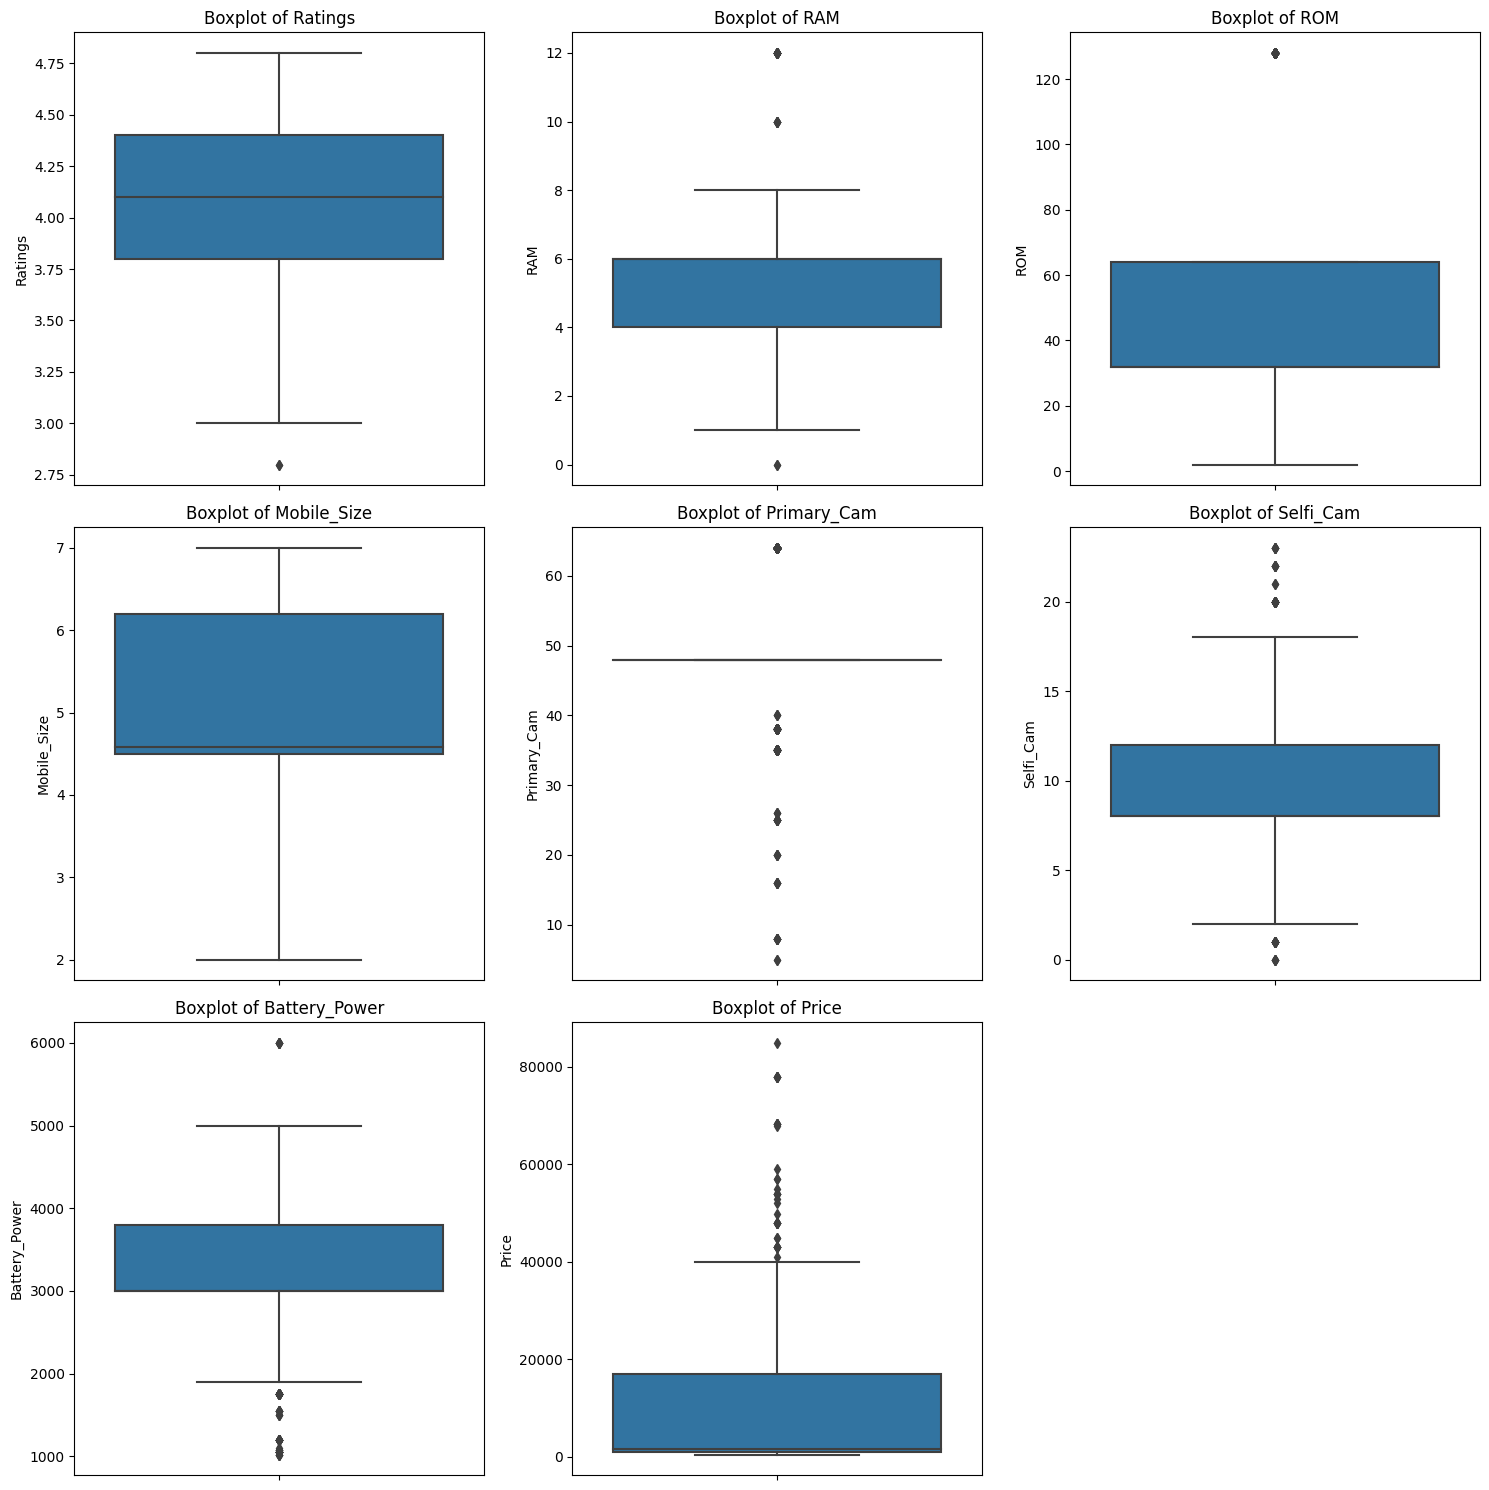

In [10]:
num_columns = 3
num_plots = len(df.columns) - 1
num_rows = (num_plots + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df_clean.columns):
    sns.boxplot(y=df_clean[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# TRAINING MODELS

In [11]:
X = df_clean.drop('Price', axis=1)
y = df_clean['Price']

# Divide
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': LGBMRegressor()
}

# training models
results = {'Model': [], 'MSE': [], 'RMSE': [], 'R2': []}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results['Model'].append(name)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)
    print(f'{name} - MSE: {mse}, RMSE: {rmse}, R2: {r2}')

results_df = pd.DataFrame(results)


Linear Regression - MSE: 95372180.5760507, RMSE: 9765.868142466941, R2: 0.6125964658474262
Decision Tree Regressor - MSE: 24159688.433016293, RMSE: 4915.250597173687, R2: 0.9018629056560977
Random Forest Regressor - MSE: 15703287.183716284, RMSE: 3962.73733468625, R2: 0.9362129615151931
Gradient Boosting Regressor - MSE: 14421395.3181458, RMSE: 3797.551226533462, R2: 0.9414200296153865
AdaBoost Regressor - MSE: 41191641.8489803, RMSE: 6418.071505443072, R2: 0.8326788007419298
Support Vector Regressor - MSE: 327222349.5110288, RMSE: 18089.288253301424, R2: -0.32918314217630784
K-Nearest Neighbors Regressor - MSE: 28719788.14373333, RMSE: 5359.084636739126, R2: 0.8833396975953236
XGBRegressor - MSE: 7956956.975512064, RMSE: 2820.8078586660354, R2: 0.9676786958755201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [12]:
results_df

,Model,MSE,RMSE,R2
0,Linear Regression,9.537218e+07,9765.868142,0.612596
1,Decision Tree Regressor,2.415969e+07,4915.250597,0.901863
2,Random Forest Regressor,1.570329e+07,3962.737335,0.936213
3,Gradient Boosting Regressor,1.442140e+07,3797.551227,0.941420
4,AdaBoost Regressor,4.119164e+07,6418.071505,0.832679
5,Support Vector Regressor,3.272223e+08,18089.288253,-0.329183
6,K-Nearest Neighbors Regressor,2.871979e+07,5359.084637,0.883340
7,XGBRegressor,7.956957e+06,2820.807859,0.967679
8,LGBMRegressor,2.183410e+07,4672.697020,0.911309


***El modelo con mejores metricas es el XGBRegressor***